# KERFIX

## France's JGOFS cruises

## 1992 - 1995

# Import libraries

In [42]:
import os
import numpy     as np
import pandas    as pd
import datetime

# For map
import map_setup           as map_setup
import matplotlib.pyplot   as plt
import cartopy.feature     as cfeature           # to add land features to map
import calendar

# Load data

In [3]:
xls_phyto         = pd.ExcelFile('../../data/datasets/unmodified/KERFIX_1992-1995_France_JGOFS/KERFIX_cleaned.xlsx')
chl_and_taxa_raw  = pd.read_excel(xls_phyto, 'chl_and_taxa_2')
T_S_nutrients_raw = pd.read_excel(xls_phyto, 'T_S_nutrients')
biogenic_si_raw   = pd.read_excel(xls_phyto, 'BSi')


xls_hydrography           = pd.ExcelFile('../../data/datasets/unmodified/KERFIX_1992-1995_France_JGOFS/hydronut.xls')
hydrography_nutrients_raw = pd.read_excel(xls_hydrography, 'hydronut-liste')

kerfix_latitude  = -50.666666666666664
kerfix_longitude =  68.41666666666667

# Organize data

In [4]:
######################## DATASETS ################################################################################
### Save raw data for manipulation
chl_and_taxa          = chl_and_taxa_raw
T_S_nutrients         = T_S_nutrients_raw
hydrography_nutrients = hydrography_nutrients_raw
biogenic_si           = biogenic_si_raw




######################## FORMAT NANs #############################################################################
### Convert n.d. (no data) to NaN
chl_and_taxa  =  chl_and_taxa.replace('n.d.', np.nan).replace('n.d', np.nan)
T_S_nutrients = T_S_nutrients.replace('n.d.', np.nan).replace('n.d', np.nan)




######################## RENAME COLUMNS ###########################################################################
### Rename columns
chl_and_taxa_sophy = {'Date':'timestamp', 'depth_m': 'depth_taxa', 
                      'Flagellates_x10^3/L':'flagellates', 'Coccolithophores_x10^3/L':'coccolithophyceae', 'Dinoflagelates_x10^3/L':'dinophyceae', 'Diatoms_x10^3/L':'bacillariophyceae', 'Total_x10^3/L':'total',
                      'Z(m)':'depth_pigs', 'Chl a': 'chl_a_fluor', 'Chl b':'chl_b', 'Chl c':'chl_c', 'Phe a':'phaeophytin', 'dégrad.':'degraded_photopigments'}
chl_and_taxa = chl_and_taxa.rename(columns=chl_and_taxa_sophy)


hydrography_nutrients_sophy = {'PStd':'pressure_standard_levels', 'Pression':'pressure', 'PCorr':'pressure_corrected', 'Temp_in_situ':'temperature', 'Salinite':'salinity', 'Oxygene':'oxygen', 
                     'TPOT':'potential_temperature', 'Sigma_theta':'sigma_theta', 'NO3':'nitrate', 'PO4':'phosphate', 'SiO2':'silicate', 'NH4':'ammonium', 
                     'Chl a':'chl_a_fluor', 'TCO2':'tco2', 'PCO2':'pco2', 'Alcalinit?':'alkalinity'}
hydrography_nutrients = hydrography_nutrients.rename(columns = hydrography_nutrients_sophy)


biogenic_si_sophy = {'depth (m)':'depth', 'BSi (mmol/m^3)':'BSi'}
biogenic_si = biogenic_si.rename(columns = biogenic_si_sophy)




######################## FORMAT DATATYPES ########################################################################
### Convert date
# Date time already formatted in dataframes for chl_and_taxa and T_S_nutrients
hydrography_nutrients['timestamp'] = hydrography_nutrients['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

biogenic_si['Month']     = pd.to_datetime(biogenic_si.Month, format='%B').dt.month   # Convert month name to integer )(i.e. March -> 3)
biogenic_si['timestamp'] = pd.to_datetime(biogenic_si[['Year', 'Month', 'Day']])     # Combine Year, Month, and Day into one timestamp column


### Make sure datatypes are all float
# All datatypes are correct




######################## DROP UNNEEDED COLUMNS ##################################################################
### Drop unneeded columns
hydrography_nutrients = hydrography_nutrients.drop(columns=['Date', 'pressure', 'mes'])
biogenic_si           = biogenic_si.drop(columns=['date', 'Year', 'Month', 'Day'])


### Drop rows without taxa
chl_and_taxa = chl_and_taxa.dropna(subset=['total'])
hydrography_nutrients = hydrography_nutrients.dropna(subset=['temperature', 'salinity', 'oxygen', 'chl_a_fluor', 'tco2', 'pco2', 'alkalinity'], how='all')




######################## UNITS ##################################################################################
### Make sure all units are the same
# Taxa units are number *10^3 per liter
chl_and_taxa['flagellates']       = chl_and_taxa['flagellates'].apply(lambda x: x * 10e3)
chl_and_taxa['coccolithophyceae'] = chl_and_taxa['coccolithophyceae'].apply(lambda x: x * 10e3)
chl_and_taxa['dinophyceae']       = chl_and_taxa['dinophyceae'].apply(lambda x: x * 10e3)
chl_and_taxa['bacillariophyceae'] = chl_and_taxa['bacillariophyceae'].apply(lambda x: x * 10e3)

# Make depths positive
hydrography_nutrients['pressure_corrected'] = hydrography_nutrients['pressure_corrected'].apply(lambda x: x * -1)
biogenic_si['depth'] = biogenic_si['depth'].apply(lambda x: x * -1)




######################## MERGE DATA FRAMES #####################################################################
### Merge dataframes together
# Merge BSi into hydrography_nutrients
biogenic_si.rename(columns={'depth':'pressure_standard_levels'}, inplace=True)
hydrography_nutrients_bsi = hydrography_nutrients.merge(biogenic_si, on=['timestamp', 'pressure_standard_levels'], how='left')


# Merge MLD from T_S_nutrients into hydrography_nutrients_bsi
T_S_nutrients.drop(T_S_nutrients[['Temperature_degC', 'Temperature_degC_stdev', 'Salinity_psu', 'Salinity_psu_stdev', 'nitrate_mM_perm3', 'nitrate_mM_perm3_stdev', 'silicate_mM_perm3', 'silicate_mM_perm3_stdev']], axis=1, inplace=True)
T_S_nutrients.rename(columns={'Date ':'timestamp'}, inplace=True)
hydrography_nutrients_bsi_mld = hydrography_nutrients_bsi.merge(T_S_nutrients, on=['timestamp'], how='left')

# Organize column order
hydrography_nutrients_bsi_mld = hydrography_nutrients_bsi_mld[['timestamp', 'pressure_standard_levels', 'pressure_corrected', 'temperature', 'potential_temperature', 'salinity', 'sigma_theta', 
                                                               'MLD_m', 'oxygen', 'nitrate', 'ammonium', 'phosphate', 'silicate', 'BSi', 'tco2', 'pco2', 'alkalinity']]


# Merge in chl_and_taxa dataframe
# Organize chl_and_taxa dataframe and drop unneeded columns
chl_and_taxa = chl_and_taxa[['timestamp', 'Depth_m', 'chl_a_fluor', 'chl_b', 'chl_c', 'phaeophytin', 'degraded_photopigments', 'flagellates', 'coccolithophyceae', 'dinophyceae', 'bacillariophyceae', 'total']]
chl_and_taxa.rename(columns={'Depth_m':'pressure_standard_levels'}, inplace=True)
hydrography_nutrients_bsi_mld_taxa = hydrography_nutrients_bsi_mld.merge(chl_and_taxa, on=['timestamp', 'pressure_standard_levels'], how='left')

# Drop rows without taxa
hydrography_nutrients_bsi_mld_taxa = hydrography_nutrients_bsi_mld_taxa.dropna(subset=['total']).reset_index()




######################## SOPHY COLUMN NAMES ################################################
### Add in columns needed for SOPhy
# Add source name
hydrography_nutrients_bsi_mld_taxa.insert(0, 'source_name', 'KERFIX')

# Add ID
hydrography_nutrients_bsi_mld_taxa.insert(1, 'sample_id', hydrography_nutrients_bsi_mld_taxa.index + 1)

# Add latitude and longitude
hydrography_nutrients_bsi_mld_taxa.insert(2, 'latitude',  kerfix_latitude)
hydrography_nutrients_bsi_mld_taxa.insert(3, 'longitude', kerfix_longitude)

# Add in which data is available
hydrography_nutrients_bsi_mld_taxa['hplc_present']       = 0
hydrography_nutrients_bsi_mld_taxa['chemtax_present']    = 0
hydrography_nutrients_bsi_mld_taxa['microscopy_present'] = 1
hydrography_nutrients_bsi_mld_taxa['ifcb_present']       = 0
# add in flowcam

# Set names to match SOPhy columns
hydrography_nutrients_bsi_mld_taxa.rename(columns={'pressure_standard_levels':'depth'}, inplace=True)




######################## FORMAT FOR SCHEMA ################################################
### Make separate dataframe to match SOPhy schema
kerfix_sample = hydrography_nutrients_bsi_mld_taxa[['source_name', 'sample_id', 'latitude', 'longitude', 'timestamp', 'depth', 'temperature', 'potential_temperature',
                                                    'salinity', 'sigma_theta', 'MLD_m', 'oxygen', 'nitrate', 'ammonium', 'phosphate', 'silicate', 'BSi', 
                                                    'tco2', 'pco2', 'alkalinity', 'chl_a_fluor', 'chl_b', 'chl_c', 'phaeophytin', 'degraded_photopigments',
                                                    'hplc_present', 'chemtax_present', 'microscopy_present', 'ifcb_present']]

kerfix_sample_amount_wide = hydrography_nutrients_bsi_mld_taxa[['source_name', 'sample_id', 'timestamp', 'depth', 'flagellates', 'coccolithophyceae', 'dinophyceae', 'bacillariophyceae']]


# Format sample_amount dataframe
kerfix_sample_amount = pd.melt(kerfix_sample_amount_wide, id_vars=['source_name', 'sample_id', 'timestamp', 'depth'], value_vars=['flagellates', 'coccolithophyceae', 'dinophyceae', 'bacillariophyceae'], var_name='taxa', value_name='cells_per_L')
kerfix_sample_amount.sort_values(by=['sample_id', 'timestamp', 'depth'], inplace=True)
kerfix_sample_amount = kerfix_sample_amount[['sample_id', 'taxa', 'cells_per_L']]

# kerfix_sample_amount['hplc_present']       = 0
# kerfix_sample_amount['chemtax_present']    = 0
# kerfix_sample_amount['microscopy_present'] = 1
# kerfix_sample_amount['ifcb_present']       = 0

# to do: add this in
kerfix_sample_amount['measurement_method'] = 'microscopy'

In [107]:
kerfix_sample_amount_wide

,source_name,id,timestamp,depth,flagellates,coccolithophyceae,dinophyceae,bacillariophyceae
0,KERFIX,1,1992-11-24,50,2054160.0,951000.0,190200.0,57060.0
1,KERFIX,2,1992-11-24,100,1386800.0,655800.0,290300.0,344000.0
2,KERFIX,3,1992-12-17,0,1247400.0,2882900.0,277200.0,623700.0
3,KERFIX,4,1992-12-17,30,1908200.0,1352800.0,341800.0,1466700.0
4,KERFIX,5,1992-12-17,100,29410000.0,2960000.0,1044000.0,3568000.0
...,...,...,...,...,...,...,...,...
69,KERFIX,70,1995-01-08,50,2293000.0,522000.0,109800.0,13700.0
70,KERFIX,71,1995-01-08,100,2900000.0,206200.0,155000.0,103000.0
71,KERFIX,72,1995-02-27,0,3047200.0,542100.0,205100.0,161210.0
72,KERFIX,73,1995-02-27,20,1664600.0,335200.0,254300.0,NaN


In [5]:
kerfix_sample_amount

,sample_id,taxa,cells_per_L,hplc_present,chemtax_present,microscopy_present,ifcb_present
0,1,flagellates,2054160.0,0,0,1,0
74,1,coccolithophyceae,951000.0,0,0,1,0
148,1,dinophyceae,190200.0,0,0,1,0
222,1,bacillariophyceae,57060.0,0,0,1,0
1,2,flagellates,1386800.0,0,0,1,0
...,...,...,...,...,...,...,...
294,73,bacillariophyceae,NaN,0,0,1,0
73,74,flagellates,4920000.0,0,0,1,0
147,74,coccolithophyceae,1050000.0,0,0,1,0
221,74,dinophyceae,100000.0,0,0,1,0


In [6]:
kerfix_sample  # note make this column just 'id'

,source_name,sample_id,latitude,longitude,timestamp,depth,temperature,potential_temperature,salinity,sigma_theta,...,alkalinity,chl_a_fluor,chl_b,chl_c,phaeophytin,degraded_photopigments,hplc_present,chemtax_present,microscopy_present,ifcb_present
0,KERFIX,1,-50.666667,68.416667,1992-11-24,50,2.705,2.703,33.8380,26.98358,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
1,KERFIX,2,-50.666667,68.416667,1992-11-24,100,NaN,NaN,33.8490,NaN,...,2.332000,NaN,NaN,NaN,NaN,NaN,0,0,1,0
2,KERFIX,3,-50.666667,68.416667,1992-12-17,0,NaN,NaN,33.8660,NaN,...,NaN,0.65270,0.04362,0.24739,0.07619,0.104529,0,0,1,0
3,KERFIX,4,-50.666667,68.416667,1992-12-17,30,3.009,3.007,33.8430,26.96091,...,2.330806,1.14500,0.10137,0.41518,0.19858,0.147799,0,0,1,0
4,KERFIX,5,-50.666667,68.416667,1992-12-17,100,2.696,2.691,33.8540,26.99740,...,2.328794,0.69916,0.06899,0.24913,0.16172,0.187854,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,KERFIX,70,-50.666667,68.416667,1995-01-08,50,3.164,3.161,33.8999,26.99200,...,NaN,0.49329,0.02724,0.16789,0.07335,0.129447,0,0,1,0
70,KERFIX,71,-50.666667,68.416667,1995-01-08,100,NaN,NaN,33.9078,NaN,...,NaN,0.52566,0.04094,0.17966,0.13784,0.207747,0,0,1,0
71,KERFIX,72,-50.666667,68.416667,1995-02-27,0,4.144,4.144,33.8454,26.85300,...,NaN,0.29272,0.01937,0.09951,0.02409,0.076039,0,0,1,0
72,KERFIX,73,-50.666667,68.416667,1995-02-27,20,NaN,NaN,33.8401,NaN,...,NaN,0.27494,0.01695,0.09367,0.02465,0.082279,0,0,1,0


# Make a map to show where data is

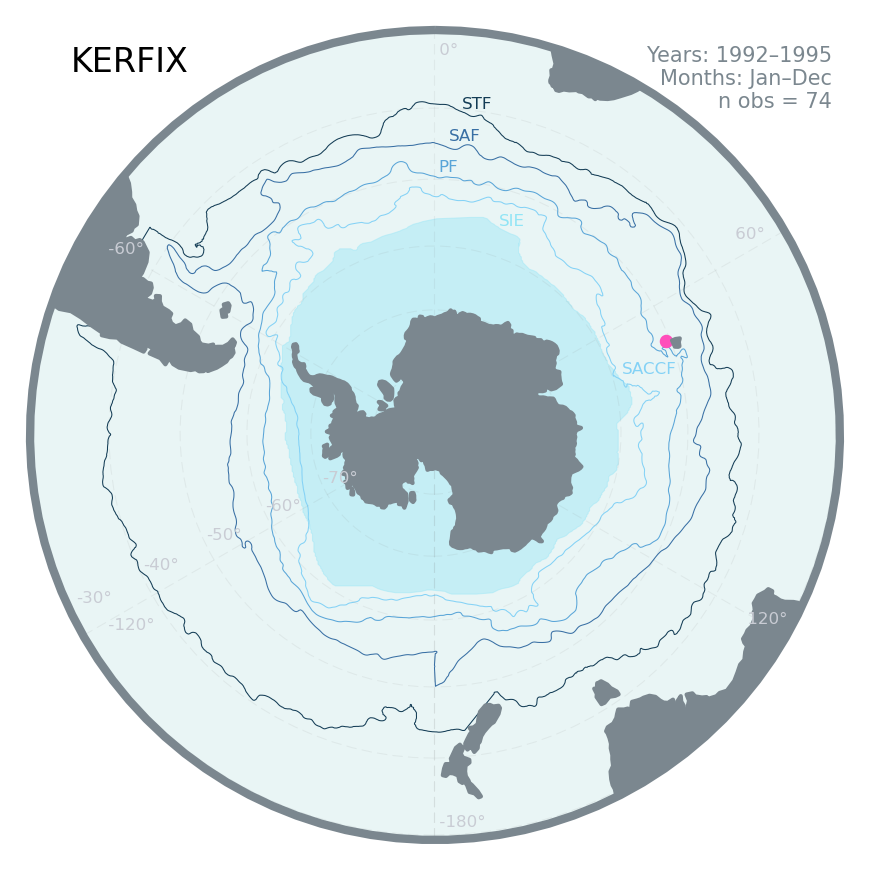

In [79]:
############ DATA TO PLOT ################################################
dataset        = kerfix_sample
data_longitude = kerfix_longitude
data_latitude  = kerfix_latitude


############ SET UP PLOT ################################################

#### COLORS
data_point_color = '#FF4FBB'

#### FIGURE SIZE
fig_width  = 3   # inches
fig_height = 3   # inches
markersize = 5

#### CREATE FIGURE
fig  = plt.figure(figsize=[fig_width, fig_height], dpi=300) # inches
ax1  = plt.subplot(projection = map_setup.map_proj)



############ CREATE MAP ################################################

# Make map
map_setup.map_southern_ocean_axes_setup(ax1, fig, add_gridlines=True)

# Add fronts to map
map_setup.add_fronts(ax1, add_labels=True, front_linewidth=0.25, fontsize=4)

# Add land after front
ax1.add_feature(cfeature.LAND, zorder=7, linewidth = 1, edgecolor=map_setup.overplot_label_color, facecolor=map_setup.overplot_label_color)



############ ADD DATA TO MAP ################################################
plt.scatter(x=data_longitude, y=data_latitude, c=data_point_color, transform=map_setup.text_proj, zorder=6, s=markersize)



############ FORMAT TITLE ###################################################
# Get source name and number of observations
source_name_title = np.unique(dataset.source_name)[0]
n_obs = len(dataset.index)

# Find range of years
first_year = np.nanmin(dataset.timestamp).astype(str)[0:4]
last_year  = np.nanmax(dataset.timestamp).astype(str)[0:4]

if first_year != last_year:
    years = first_year + u'\u2013' + last_year
if first_year == last_year:
    years = first_year

# Find range of months
month_array = []
for i in range(0,len(dataset.index)):
    month = dataset.timestamp[i].month
    month_array.append(month)
        
first_month = np.nanmin(month_array)
last_month  = np.nanmax(month_array)

months = calendar.month_abbr[first_month] + u'\u2013' + calendar.month_abbr[last_month]


plt.title(source_name_title, loc='left', x=0.05, y=.95, va='top', fontsize=8)
# plt.suptitle('Years: ' + years + '\nMonths: ' + months + '\nn obs = ' + str(n_obs), x=.05, y=.95, fontsize=5, ha='left')
plt.title('Years: ' + years + '\nMonths: ' + months + '\nn obs = ' + str(n_obs), fontsize=5, loc='right', x=0.99, y=0.95, color=map_setup.overplot_label_color, va='top')


plt.show()